In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3MB 9.6MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=635309bb6f88359d88e7c243bfe92f524dcd49675eefee6120b5d58877664cd3
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import math 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from tensorflow.keras import activations
from tensorflow.keras import layers
import yfinance as yf
plt.style.use('fivethirtyeight') # специальное отображение графиков для pyplot

In [ ]:
tickers_list = ['MMM', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'XOM', 'JPM', 'GS', 'HD', 'INTC', 'IBM', 'JNJ', 'MCD', 'MRK', 'MSFT', 'NKE', 'PFE','PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT', 'DIS']

In [ ]:
df = pd.DataFrame(columns=tickers_list)

In [ ]:
for ticker in tickers_list:
    df[ticker] = yf.download(ticker,'1900-01-01','2021-06-01')['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
df

,MMM,AAPL,BA,CAT,CVX,CSCO,KO,XOM,JPM,GS,HD,INTC,IBM,JNJ,MCD,MRK,MSFT,NKE,PFE,PG,TRV,UNH,V,VZ,WBA,WMT,DIS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
1970-01-02,1.460485,NaN,0.290568,1.340877,0.492265,NaN,0.201857,0.181719,NaN,NaN,NaN,NaN,4.504755,0.407606,0.169133,0.325699,NaN,NaN,NaN,0.406697,NaN,NaN,NaN,NaN,NaN,NaN,0.454785
1970-01-05,1.468811,NaN,0.301555,1.336838,0.494620,NaN,0.198789,0.184650,NaN,NaN,NaN,NaN,4.547982,0.397735,0.172000,0.323870,NaN,NaN,NaN,0.408546,NaN,NaN,NaN,NaN,NaN,NaN,0.441107
1970-01-06,1.483799,NaN,0.305218,1.304527,0.487554,NaN,0.200630,0.184283,NaN,NaN,NaN,NaN,4.551071,0.405284,0.172955,0.326431,NaN,NaN,NaN,0.406697,NaN,NaN,NaN,NaN,NaN,NaN,0.432559
1970-01-07,1.492126,NaN,0.306439,1.264139,0.486377,NaN,0.201857,0.183184,NaN,NaN,NaN,NaN,4.554159,0.403542,0.172000,0.323504,NaN,NaN,NaN,0.413168,NaN,NaN,NaN,NaN,NaN,NaN,0.443671
1970-01-08,1.512109,NaN,0.302776,1.268178,0.495798,NaN,0.202164,0.183551,NaN,NaN,NaN,NaN,4.563419,0.406445,0.172000,0.325699,NaN,NaN,NaN,0.417789,NaN,NaN,NaN,NaN,NaN,NaN,0.454785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,202.610001,127.099998,237.440002,239.050003,105.599998,53.389999,54.390167,59.610001,163.539993,367.050354,313.197662,56.959999,144.720001,170.550003,230.636215,74.767632,250.779999,133.790039,39.810001,137.960007,157.843338,409.450378,229.320007,56.980000,54.830002,141.759995,174.309998
2021-05-25,201.710007,126.900002,240.740005,237.169998,103.870003,53.310001,54.380245,58.259998,161.850006,363.283081,315.097687,56.869999,143.789993,170.080002,230.864944,73.320152,251.720001,134.049515,39.330002,138.429993,155.675522,411.542694,229.020004,56.480000,54.189999,142.339996,176.169998
2021-05-26,201.580002,126.849998,241.369995,237.710007,104.120003,52.910000,54.618450,58.939999,161.830002,366.163361,315.674652,56.919998,143.380005,169.070007,231.073792,73.064713,251.490005,136.614334,38.919998,138.119995,156.262222,411.702118,227.070007,56.360001,52.009998,142.169998,176.470001


In [ ]:
df=df.fillna(method='bfill')

In [ ]:
def SMA(X, w=5):
    return np.sum(X[len(X)-w:])/w

In [ ]:
def EMA(X, t=5, alpha=0.2):
    result=np.zeros((1,X.shape[1]),dtype=float)
    for i in range(min(t,len(X))):
        result+=alpha*((1-alpha)**i)*X[len(X)-i-1:len(X)-i].values
    return result

In [ ]:
def DEMA(X, t=5, alpha=0.2):
    result=2*EMA(X,t,alpha)
    ema_arrays=np.zeros((t,X.shape[1]),dtype=float)
    for i in range(t):
        ema_arrays[i]+=EMA(X[:(len(X) if i==0 else -i)],t,alpha)[0]
    result-=EMA(pd.DataFrame(ema_arrays),t,alpha)
    return result

In [ ]:
def TEMA(X,t=5,alpha=0.2):
    result=3*EMA(X,t,alpha)
    ema_arrays=np.zeros((t*2,X.shape[1]),dtype=float)
    ema_arrays2=np.zeros((t,X.shape[1]),dtype=float)
    for i in range(t*2):
        ema_arrays[i]+=EMA(X[:(len(X) if i==0 else -i)],t,alpha)[0]
    result-=3*EMA(pd.DataFrame(ema_arrays),t,alpha)
    for i in range(t):
        ema_arrays2[i]+=EMA(pd.DataFrame(ema_arrays[:(len(X) if i==0 else -i)]),t,alpha)[0]
    result+=EMA(pd.DataFrame(ema_arrays2))
    return result

In [ ]:
print(df.columns)
df[-1:].values/df[:1].values

Index(['MMM', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'XOM', 'JPM', 'GS',
       'HD', 'INTC', 'IBM', 'JNJ', 'MCD', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG',
       'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT', 'DIS'],
      dtype='object')


array([[1.39022320e+02, 1.23681460e+03, 8.50129278e+02, 1.79792835e+02,
        2.10841831e+02, 9.22181036e+02, 2.71858088e+02, 3.21210284e+02,
        1.40131543e+02, 6.83357152e+00, 1.69686482e+04, 2.87996721e+02,
        3.19085033e+01, 4.15229103e+02, 1.38287309e+03, 2.20439395e+02,
        4.05269570e+03, 1.03252397e+03, 2.08706306e+02, 3.31573494e+02,
        4.87829044e+01, 3.41258367e+03, 1.76349217e+01, 4.06181413e+01,
        4.42586338e+02, 3.86701191e+03, 3.92823107e+02]])

In [ ]:
window=10
result_sum=1.0
result_sum_array=[]
for i in range(window,len(df)):
    index=np.argmax(DEMA(df[:i],window,1.0/window)/df[i-1:i])
    result_sum*=df[df.columns[index]][i]/df[df.columns[index]][i-1]
    result_sum_array.append(result_sum)

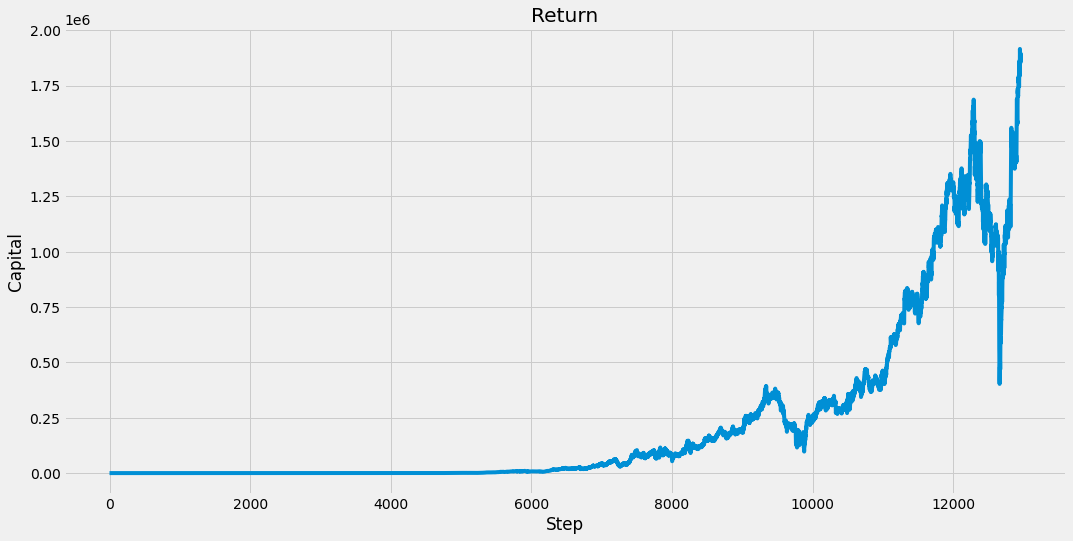

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Return')
plt.plot(result_sum_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

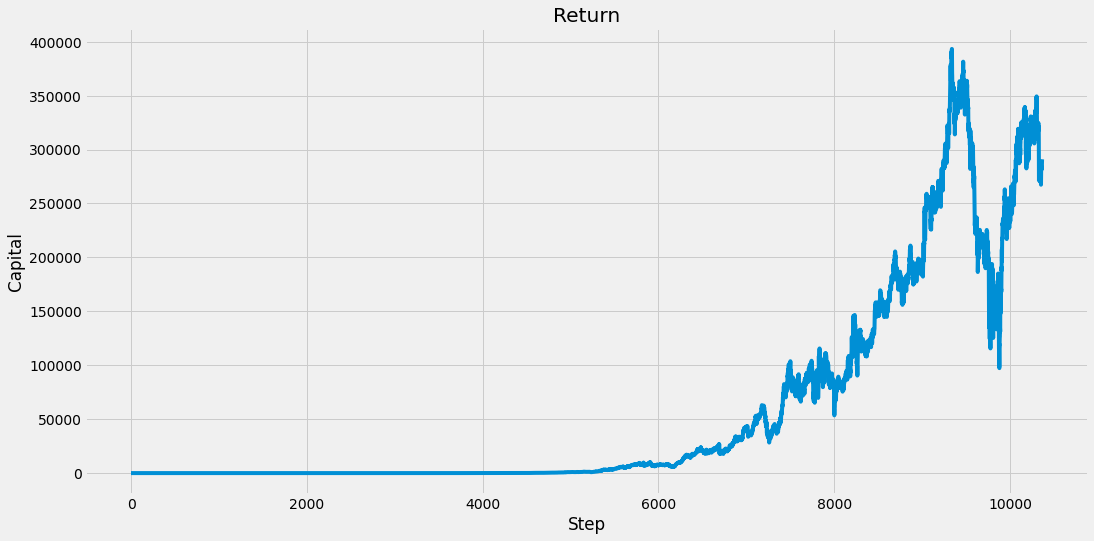

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Return')
plt.plot(result_sum_array[:int(len(result_sum_array)*0.8)])
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

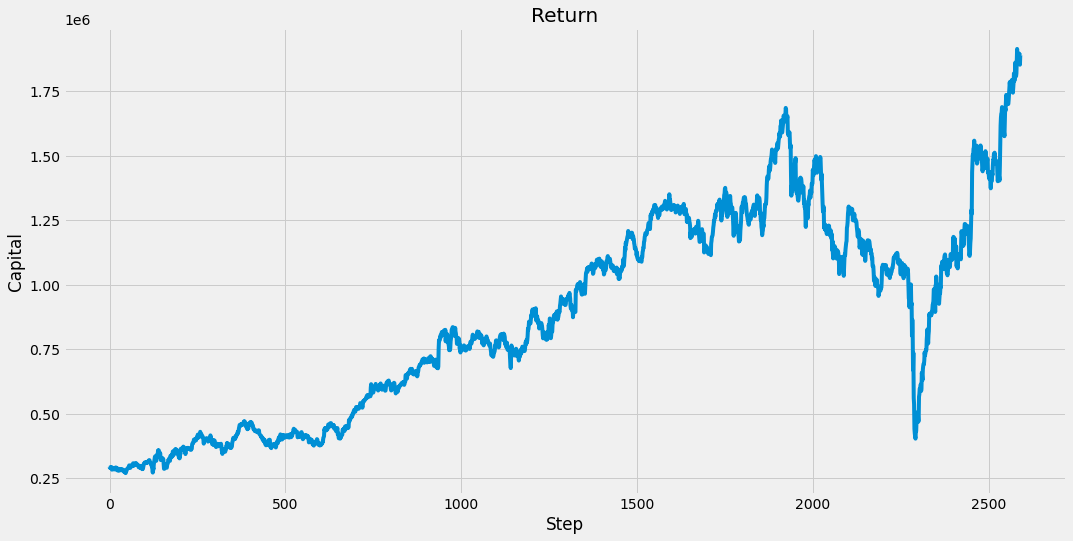

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Return')
plt.plot(result_sum_array[int(len(result_sum_array)*0.8):])
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

In [ ]:
window=10
result_sum=1.0
coef=0.8

In [ ]:
result_sum=1.0
Y=[]

for i in range(window,len(df)-1):
    Y.append(EMA(df[:i],window,1.0/window)/df[i-1:i])

In [ ]:
Y=np.array(Y).reshape(-1,np.array(Y).shape[2])

In [ ]:
result_sum=1.0
result_sum_array=[]
for i in range(len(Y)-1):
    index=np.argmax(Y[i])
    result_sum*=df[df.columns[index]][window+i]/df[df.columns[index]][window+i-1]
    result_sum_array.append(result_sum)

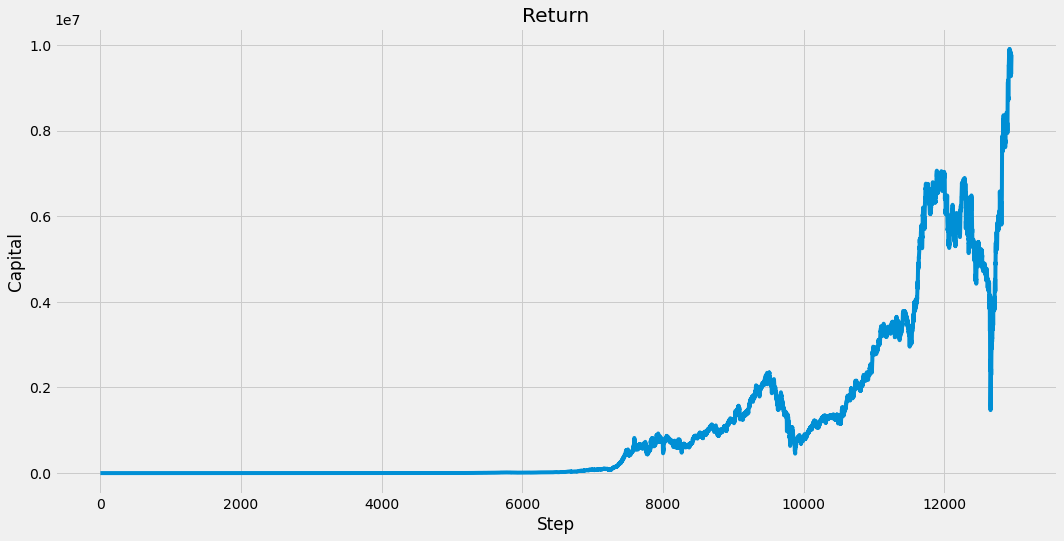

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Return')
plt.plot(result_sum_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

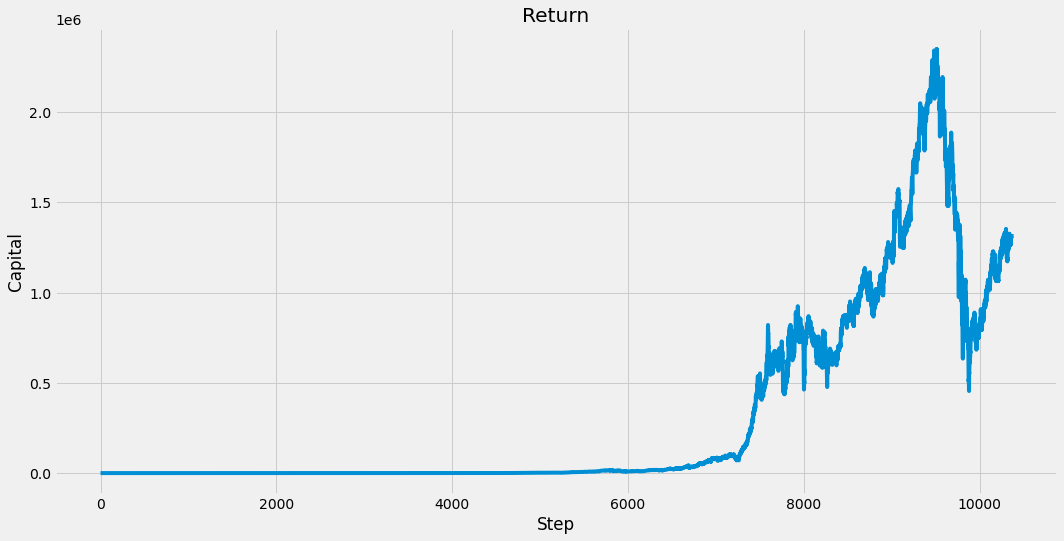

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Return')
plt.plot(result_sum_array[:int(len(result_sum_array)*coef)])
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

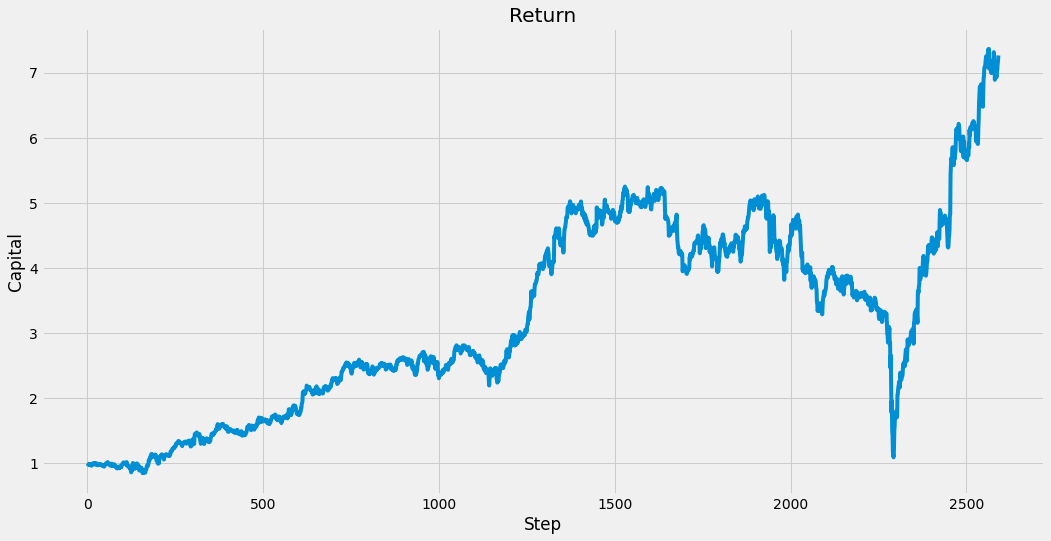

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Return')
plt.plot(result_sum_array[int(len(result_sum_array)*coef):]/result_sum_array[int(len(result_sum_array)*coef)])
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

In [ ]:
Y_train=Y[:int(len(Y)*coef)]
Y_test=Y[int(len(Y)*coef):]
# print(Y[:int(len(Y)*coef)].shape)

In [ ]:
Y_train[0]

array([0.6545098 , 0.65132156, 0.69717424, 0.65618793, 0.67285466,
       0.65132156, 0.63751788, 0.65898885, 0.65132156, 0.65132156,
       0.65132156, 0.65132156, 0.63469111, 0.64334629, 0.68022298,
       0.65579197, 0.65132156, 0.65132156, 0.65132156, 0.64968545,
       0.65132156, 0.65132156, 0.65132156, 0.65132156, 0.65132156,
       0.65132156, 0.6134619 ])

In [ ]:
result_sum_train=1.0
result_sum_train_array=[]
for i in range(len(Y_train)):
    
    index=np.argmax(Y_train[i])
    result_sum_train*=df[df.columns[index]][window+i]/df[df.columns[index]][window+i-1]
    # print(Y_train[i+1][index]/Y_train[i][index])
    result_sum_train_array.append(result_sum_train)

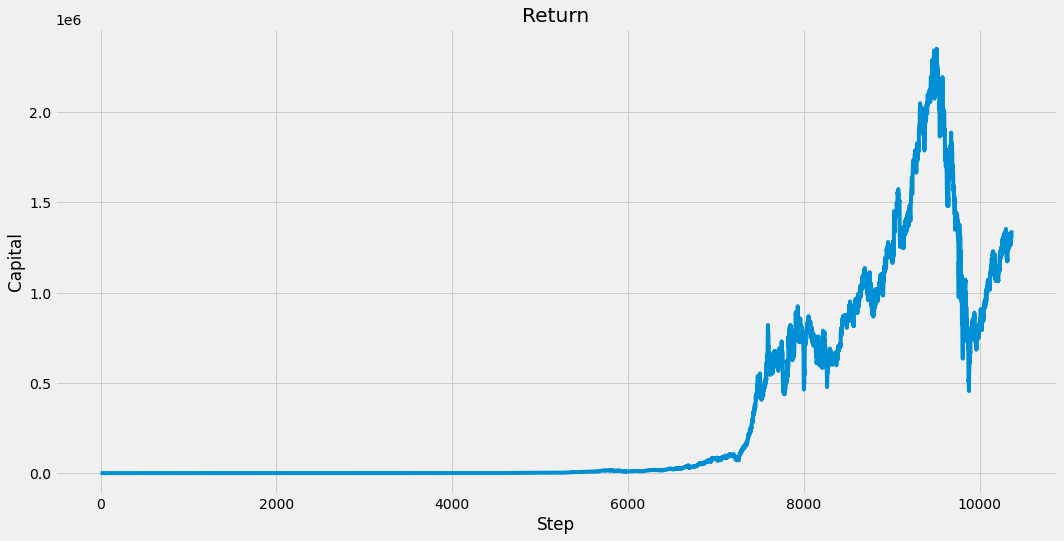

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Return')
plt.plot(result_sum_train_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

In [ ]:
result_sum_test=1.0
result_sum_test_array=[]
for i in range(len(Y_test)):
    
    index=np.argmax(Y_test[i])
    
    result_sum_test*=df[df.columns[index]][len(Y_train)+window+i+1]/df[df.columns[index]][len(Y_train)+window+i]
    
    result_sum_test_array.append(result_sum_test)

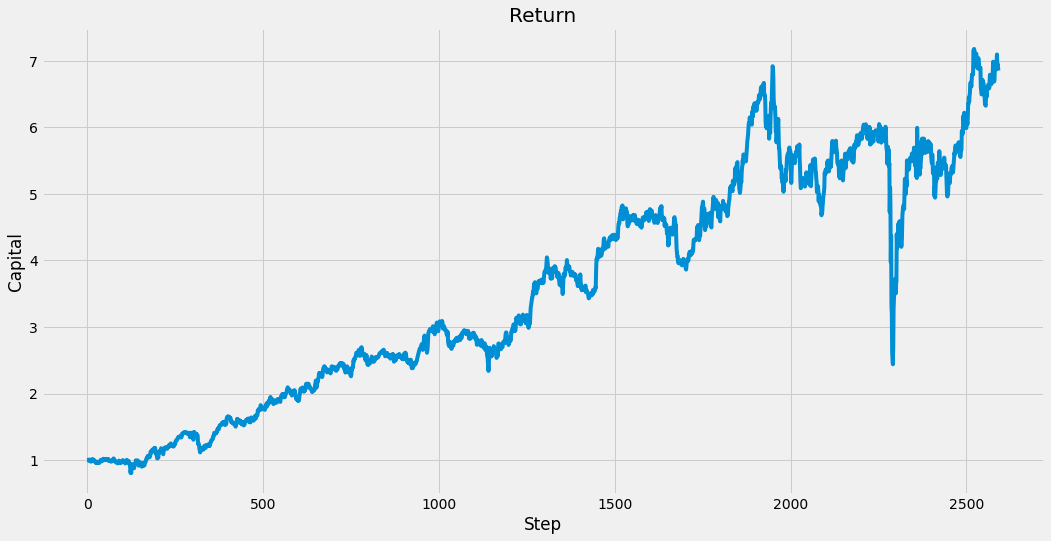

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Return')
plt.plot(result_sum_test_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

In [ ]:
print(result_sum)
print(result_sum_train)
print(result_sum_test)

9770756.135825317
1345486.2979300986
6.854027284615761


#Подготовка X_train и X_test

In [ ]:
Y_train=Y[:int(len(Y)*coef)]
Y_test=Y[int(len(Y)*coef):]

In [ ]:
valid_size=0.1
X_train=[]
X_test=[]
X_valid=[]
Y_valid=[]

for i in range(window,len(Y_train)+window):
    X_train.append(df[i-window:i].values)
X_train=np.array(X_train)

X_valid=X_train[:int(len(X_train)*0.1)]
Y_valid=Y_train[:int(len(Y_train)*0.1)]

X_train=X_train[int(len(X_train)*0.1):]
Y_train=Y_train[int(len(Y_train)*0.1):]

for i in range(len(Y_train)+window,len(Y_test)+len(Y_train)+window):
    X_test.append(df[i-window:i].values)
X_test=np.array(X_test)

In [ ]:
print(Y_train.shape)
print(Y_valid.shape)
print(Y_test.shape)

(9329, 27)
(1036, 27)
(2592, 27)


In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(9329, 10, 27)
(1036, 10, 27)
(2592, 10, 27)


# ANN learning

In [ ]:
#Строим нейронку
model = Sequential()
model.add(SimpleRNN(50,return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
model.add(SimpleRNN(50,return_sequences = False))
model.add(Dense(25))
model.add(Dense(Y_train.shape[1]))

In [ ]:
#Компилируем модель
model.compile(optimizer='adam',loss = 'mean_squared_error')

In [ ]:
#Тренируем модель
model.fit(X_train,Y_train,batch_size = 1, epochs = 20,validation_data=(X_valid,Y_valid))

Epoch 1/20
9329/9329 [==============================] - 61s 4ms/step - loss: 0.0116 - val_loss: 2.9130e-04
Epoch 2/20
9329/9329 [==============================] - 36s 4ms/step - loss: 5.3745e-04 - val_loss: 2.9440e-04
Epoch 3/20
9329/9329 [==============================] - 37s 4ms/step - loss: 4.7186e-04 - val_loss: 1.9068e-04
Epoch 4/20
9329/9329 [==============================] - 37s 4ms/step - loss: 4.6087e-04 - val_loss: 2.9503e-04
Epoch 5/20
9329/9329 [==============================] - 36s 4ms/step - loss: 4.2403e-04 - val_loss: 2.3975e-04
Epoch 6/20
9329/9329 [==============================] - 36s 4ms/step - loss: 4.1314e-04 - val_loss: 2.1298e-04
Epoch 7/20
9329/9329 [==============================] - 38s 4ms/step - loss: 3.9485e-04 - val_loss: 3.2414e-04
Epoch 8/20
9329/9329 [==============================] - 37s 4ms/step - loss: 3.9063e-04 - val_loss: 2.4623e-04
Epoch 9/20
9329/9329 [==============================] - 37s 4ms/step - loss: 3.8150e-04 - val_loss: 2.2667e-04
Epoch

In [ ]:
y_train_pred=model.predict(X_train)
y_valid_pred=model.predict(X_valid)
y_test_pred=model.predict(X_test)

In [ ]:
print(y_train_pred.shape)
print(y_valid_pred.shape)
print(y_test_pred.shape)

(9329, 27)
(1036, 27)
(2592, 27)


In [ ]:
np.vstack([y_train_pred,y_valid_pred]).shape

(10365, 27)

In [ ]:
y_train_np=np.vstack([y_train_pred,y_valid_pred])
y_test_np=y_test_pred

# Проверка результативности

In [ ]:
count_max=0
count_plus=0
count_min=0
count_minus=0


result_sum_train=1.0
result_sum_train_array=[]
for i in range(len(y_train_np)):
    
    index=np.argmax(y_train_np[i])

    count_max+=1 if index==np.argmax(df[window+i:window+i+1].values/df[window+i-1:window+i].values) else 0
    count_plus+=1 if df[df.columns[index]][window+i]/df[df.columns[index]][window+i-1]>1 else 0
    count_min+=1 if np.argmin(y_train_np[i])==np.argmin(df[window+i:window+i+1].values/df[window+i-1:window+i].values) else 0
    count_minus+=1 if df[df.columns[np.argmin(y_train_np[i])]][window+i]/df[df.columns[np.argmin(y_train_np[i])]][window+i-1]<1 else 0

    result_sum_train*=df[df.columns[index]][window+i]/df[df.columns[index]][window+i-1]
    result_sum_train_array.append(result_sum_train)

In [ ]:
print("probability of guessing the highest growth: {0:.2%}".format(count_max/len(y_train_np)))
print("probability of guessing the growth up: {0:.2%}".format(count_plus/len(y_train_np)))
print("probability of guessing the lowest growth: {0:.2%}".format(count_min/len(y_train_np)))
print("probability of guessing the growth down: {0:.2%}".format(count_minus/len(y_train_np)))

probability of guessing the highest growth: 2.96%
probability of guessing the growth up: 39.66%
probability of guessing the lowest growth: 5.48%
probability of guessing the growth down: 41.78%


In [ ]:
print("deposit increase per day:{}%".format((result_sum_train**(1/len(y_train_np))-1)*100))

deposit increase per day:0.025298523663686012%


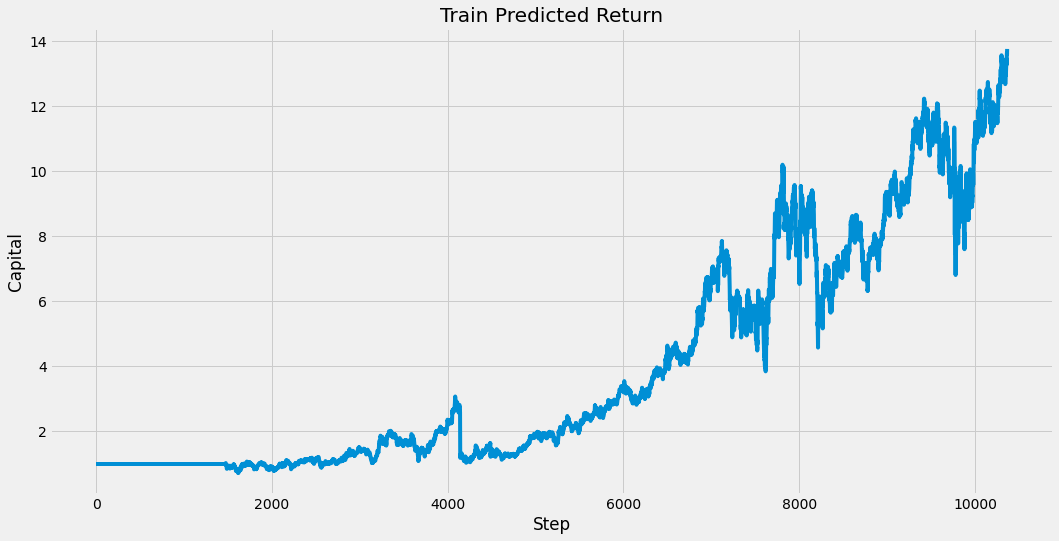

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Train Predicted Return')
plt.plot(result_sum_train_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

In [ ]:
count_max=0
count_plus=0
count_min=0
count_minus=0

result_sum_test=1.0
result_sum_test_array=[]
for i in range(len(y_test_np)):
    
    index=np.argmax(y_test_np[i])
    
    count_max+=1 if index==np.argmax(df[len(Y_train)+window+i:len(Y_train)+window+i+1].values/df[len(Y_train)+window+i-1:len(Y_train)+window+i].values) else 0
    count_plus+=1 if df[df.columns[index]][len(Y_train)+window+i]/df[df.columns[index]][len(Y_train)+window+i-1]>1 else 0
    count_min+=1 if np.argmin(y_test_np[i])==np.argmin(df[len(Y_train)+window+i:len(Y_train)+window+i+1].values/df[len(Y_train)+window+i-1:len(Y_train)+window+i].values) else 0
    count_minus+=1 if df[df.columns[np.argmin(y_test_np[i])]][len(Y_train)+window+i]/df[df.columns[np.argmin(y_test_np[i])]][len(Y_train)+window+i-1]<1 else 0

    result_sum_test*=df[df.columns[index]][len(Y_train)+window+i+1]/df[df.columns[index]][len(Y_train)+window+i]
    
    result_sum_test_array.append(result_sum_test)

In [ ]:
print("probability of guessing the highest growth: {0:.2%}".format(count_max/len(y_test_np)))
print("probability of guessing the growth up: {0:.2%}".format(count_plus/len(y_test_np)))
print("probability of guessing the lowest growth: {0:.2%}".format(count_min/len(y_test_np)))
print("probability of guessing the growth down: {0:.2%}".format(count_minus/len(y_test_np)))

probability of guessing the highest growth: 2.12%
probability of guessing the growth up: 52.70%
probability of guessing the lowest growth: 3.36%
probability of guessing the growth down: 47.69%


In [ ]:
print("deposit increase per day:{}%".format((result_sum_test**(1/len(y_test_np))-1)*100))

deposit increase per day:0.04089808380061122%


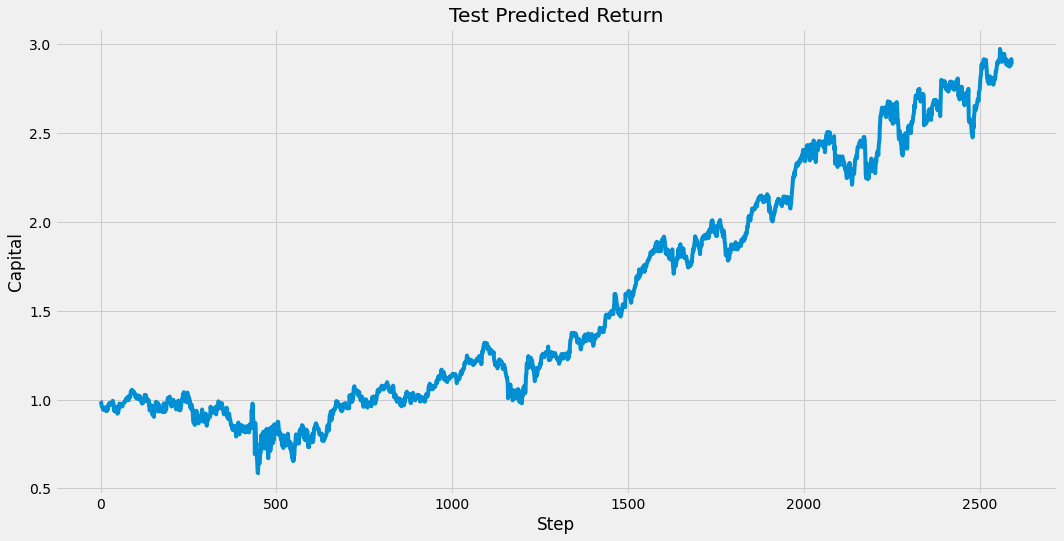

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Test Predicted Return')
plt.plot(result_sum_test_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

# ANN 2

In [ ]:
#Строим нейронку
model = Sequential()
model.add(SimpleRNN(50,return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
model.add(SimpleRNN(45,return_sequences = True))
model.add(SimpleRNN(35,return_sequences = True))
model.add(SimpleRNN(30,return_sequences = True))
model.add(SimpleRNN(20,return_sequences = True))
model.add(SimpleRNN(15,return_sequences = True))
model.add(SimpleRNN(10,return_sequences = True))
model.add(SimpleRNN(5,return_sequences = True))
model.add(SimpleRNN(10,return_sequences = True))
model.add(SimpleRNN(15,return_sequences = True))
model.add(SimpleRNN(20,return_sequences = True))
model.add(SimpleRNN(25,return_sequences = True))
model.add(SimpleRNN(30,return_sequences = True))
model.add(SimpleRNN(35,return_sequences = True))
model.add(SimpleRNN(40,return_sequences = True))
model.add(SimpleRNN(50,return_sequences = False))
model.add(Dense(25))
model.add(Dense(Y_train.shape[1]))

In [ ]:
#Компилируем модель
model.compile(optimizer='adam',loss = 'mean_squared_error')

In [ ]:
#Тренируем модель
model.fit(X_train,Y_train,batch_size = 1, epochs = 20,validation_data=(X_valid,Y_valid))

Epoch 1/20
9329/9329 [==============================] - 278s 28ms/step - loss: 0.0052 - val_loss: 5.1170e-04
Epoch 2/20
9329/9329 [==============================] - 257s 28ms/step - loss: 5.7713e-04 - val_loss: 9.6089e-04
Epoch 3/20
9329/9329 [==============================] - 260s 28ms/step - loss: 4.6908e-04 - val_loss: 2.5623e-04
Epoch 4/20
9329/9329 [==============================] - 260s 28ms/step - loss: 4.8360e-04 - val_loss: 2.2599e-04
Epoch 5/20
9329/9329 [==============================] - 262s 28ms/step - loss: 4.3019e-04 - val_loss: 2.0982e-04
Epoch 6/20
9329/9329 [==============================] - 262s 28ms/step - loss: 4.1730e-04 - val_loss: 6.4961e-04
Epoch 7/20
9329/9329 [==============================] - 259s 28ms/step - loss: 4.0479e-04 - val_loss: 2.2196e-04
Epoch 8/20
9329/9329 [==============================] - 260s 28ms/step - loss: 3.9822e-04 - val_loss: 2.2740e-04
Epoch 9/20
9329/9329 [==============================] - 262s 28ms/step - loss: 3.9383e-04 - val_loss

In [ ]:
y_train_pred=model.predict(X_train)
y_valid_pred=model.predict(X_valid)
y_test_pred=model.predict(X_test)

In [ ]:
y_train_np=np.vstack([y_train_pred,y_valid_pred])
y_test_np=y_test_pred

In [ ]:
count_max=0
count_plus=0
count_min=0
count_minus=0


result_sum_train=1.0
result_sum_train_array=[]
for i in range(len(y_train_np)):
    
    index=np.argmax(y_train_np[i])

    count_max+=1 if index==np.argmax(df[window+i:window+i+1].values/df[window+i-1:window+i].values) else 0
    count_plus+=1 if df[df.columns[index]][window+i]/df[df.columns[index]][window+i-1]>1 else 0
    count_min+=1 if np.argmin(y_train_np[i])==np.argmin(df[window+i:window+i+1].values/df[window+i-1:window+i].values) else 0
    count_minus+=1 if df[df.columns[np.argmin(y_train_np[i])]][window+i]/df[df.columns[np.argmin(y_train_np[i])]][window+i-1]<1 else 0

    result_sum_train*=df[df.columns[index]][window+i]/df[df.columns[index]][window+i-1]
    result_sum_train_array.append(result_sum_train)

In [ ]:
print("probability of guessing the highest growth: {0:.2%}".format(count_max/len(y_train_np)))
print("probability of guessing the growth up: {0:.2%}".format(count_plus/len(y_train_np)))
print("probability of guessing the lowest growth: {0:.2%}".format(count_min/len(y_train_np)))
print("probability of guessing the growth down: {0:.2%}".format(count_minus/len(y_train_np)))

probability of guessing the highest growth: 2.36%
probability of guessing the growth up: 48.72%
probability of guessing the lowest growth: 4.44%
probability of guessing the growth down: 46.22%


In [ ]:
print("deposit increase per day:{}%".format((result_sum_train**(1/len(y_train_np))-1)*100))

deposit increase per day:0.031026161833769272%


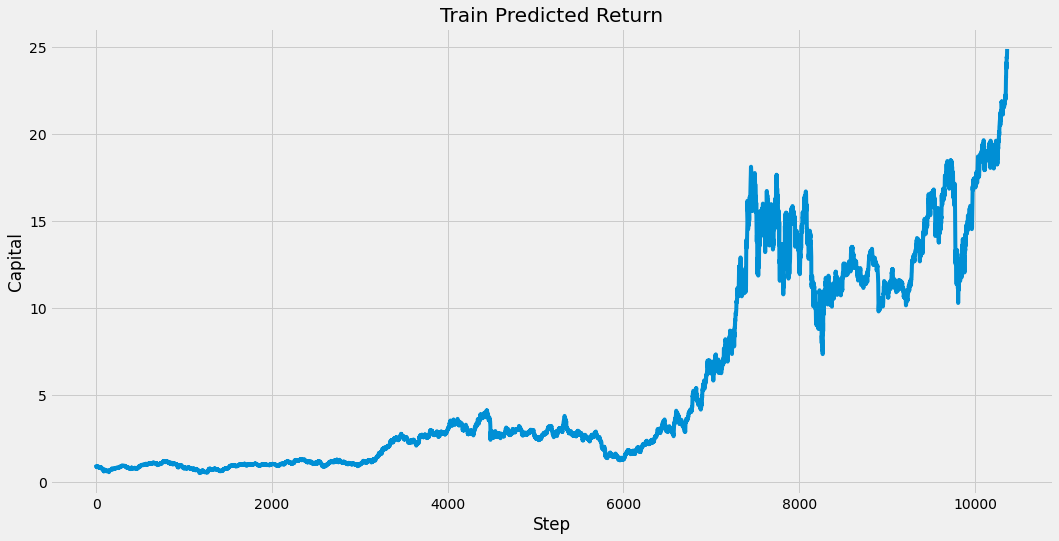

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Train Predicted Return')
plt.plot(result_sum_train_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

In [ ]:
count_max=0
count_plus=0
count_min=0
count_minus=0

result_sum_test=1.0
result_sum_test_array=[]
for i in range(len(y_test_np)):
    
    index=np.argmax(y_test_np[i])
    
    count_max+=1 if index==np.argmax(df[len(Y_train)+window+i:len(Y_train)+window+i+1].values/df[len(Y_train)+window+i-1:len(Y_train)+window+i].values) else 0
    count_plus+=1 if df[df.columns[index]][len(Y_train)+window+i]/df[df.columns[index]][len(Y_train)+window+i-1]>1 else 0
    count_min+=1 if np.argmin(y_test_np[i])==np.argmin(df[len(Y_train)+window+i:len(Y_train)+window+i+1].values/df[len(Y_train)+window+i-1:len(Y_train)+window+i].values) else 0
    count_minus+=1 if df[df.columns[np.argmin(y_test_np[i])]][len(Y_train)+window+i]/df[df.columns[np.argmin(y_test_np[i])]][len(Y_train)+window+i-1]<1 else 0

    result_sum_test*=df[df.columns[index]][len(Y_train)+window+i+1]/df[df.columns[index]][len(Y_train)+window+i]
    
    result_sum_test_array.append(result_sum_test)

In [ ]:
print("probability of guessing the highest growth: {0:.2%}".format(count_max/len(y_test_np)))
print("probability of guessing the growth up: {0:.2%}".format(count_plus/len(y_test_np)))
print("probability of guessing the lowest growth: {0:.2%}".format(count_min/len(y_test_np)))
print("probability of guessing the growth down: {0:.2%}".format(count_minus/len(y_test_np)))

probability of guessing the highest growth: 1.97%
probability of guessing the growth up: 51.23%
probability of guessing the lowest growth: 2.62%
probability of guessing the growth down: 45.06%


In [ ]:
print("deposit increase per day:{}%".format((result_sum_test**(1/len(y_test_np))-1)*100))

deposit increase per day:0.030321420494305862%


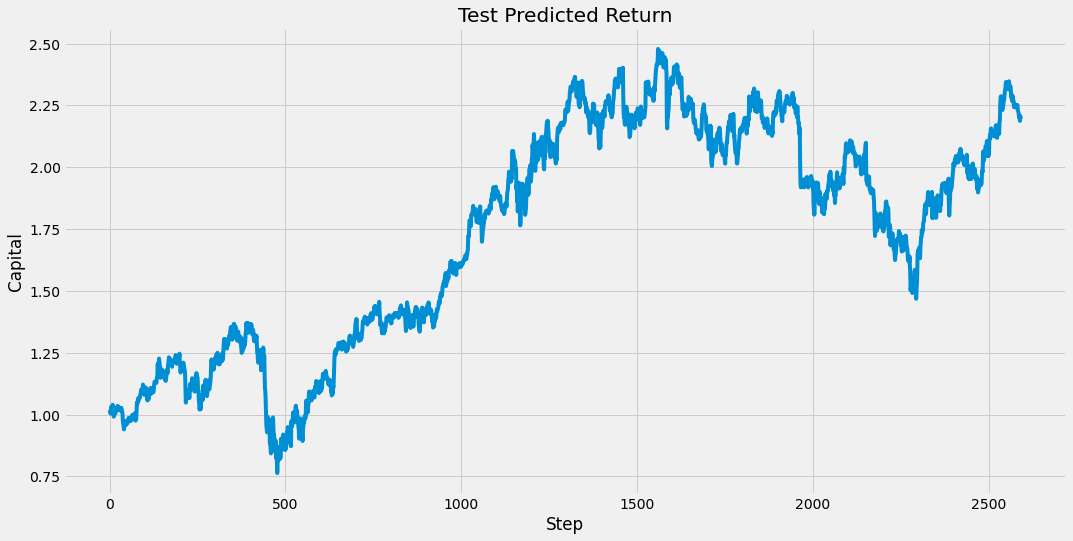

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Test Predicted Return')
plt.plot(result_sum_test_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

# ANN 3

In [ ]:
#Строим нейронку
model = Sequential()
model.add(SimpleRNN(50,return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))
model.add(SimpleRNN(45,return_sequences = True))
model.add(SimpleRNN(35,return_sequences = True))
model.add(SimpleRNN(30,return_sequences = True))
model.add(SimpleRNN(20,return_sequences = True))
model.add(SimpleRNN(15,return_sequences = True))
model.add(SimpleRNN(10,return_sequences = True))
model.add(SimpleRNN(5,return_sequences = True))
model.add(SimpleRNN(10,return_sequences = True))
model.add(SimpleRNN(15,return_sequences = True))
model.add(SimpleRNN(20,return_sequences = True))
model.add(SimpleRNN(25,return_sequences = True))
model.add(SimpleRNN(30,return_sequences = True))
model.add(SimpleRNN(35,return_sequences = True))
model.add(SimpleRNN(40,return_sequences = True))
model.add(SimpleRNN(50,return_sequences = False))
model.add(Dense(25))
model.add(Dense(Y_train.shape[1]))

In [ ]:
#Компилируем модель
model.compile(optimizer='adam',loss = 'mean_squared_error')

In [ ]:
#Тренируем модель
model.fit(X_train,Y_train,batch_size = 100, epochs = 250,validation_data=(X_valid,Y_valid))

Epoch 1/250
94/94 [==============================] - 26s 93ms/step - loss: 0.0928 - val_loss: 1.8929e-04
Epoch 2/250
94/94 [==============================] - 4s 40ms/step - loss: 3.9383e-04 - val_loss: 1.7237e-04
Epoch 3/250
94/94 [==============================] - 4s 39ms/step - loss: 3.5218e-04 - val_loss: 1.8505e-04
Epoch 4/250
94/94 [==============================] - 4s 40ms/step - loss: 3.3779e-04 - val_loss: 2.3616e-04
Epoch 5/250
94/94 [==============================] - 4s 40ms/step - loss: 3.6257e-04 - val_loss: 1.6493e-04
Epoch 6/250
94/94 [==============================] - 4s 40ms/step - loss: 3.3258e-04 - val_loss: 2.0033e-04
Epoch 7/250
94/94 [==============================] - 4s 39ms/step - loss: 3.3385e-04 - val_loss: 1.6789e-04
Epoch 8/250
94/94 [==============================] - 4s 39ms/step - loss: 3.2856e-04 - val_loss: 1.9777e-04
Epoch 9/250
94/94 [==============================] - 4s 39ms/step - loss: 3.4044e-04 - val_loss: 1.7920e-04
Epoch 10/250
94/94 [===========

In [ ]:
y_train_pred=model.predict(X_train)
y_valid_pred=model.predict(X_valid)
y_test_pred=model.predict(X_test)

In [ ]:
y_train_np=np.vstack([y_train_pred,y_valid_pred])
y_test_np=y_test_pred

In [ ]:
count_max=0
count_plus=0
count_min=0
count_minus=0


result_sum_train=1.0
result_sum_train_array=[]
for i in range(len(y_train_np)):
    
    index=np.argmax(y_train_np[i])

    count_max+=1 if index==np.argmax(df[window+i:window+i+1].values/df[window+i-1:window+i].values) else 0
    count_plus+=1 if df[df.columns[index]][window+i]/df[df.columns[index]][window+i-1]>1 else 0
    count_min+=1 if np.argmin(y_train_np[i])==np.argmin(df[window+i:window+i+1].values/df[window+i-1:window+i].values) else 0
    count_minus+=1 if df[df.columns[np.argmin(y_train_np[i])]][window+i]/df[df.columns[np.argmin(y_train_np[i])]][window+i-1]<1 else 0

    result_sum_train*=df[df.columns[index]][window+i]/df[df.columns[index]][window+i-1]
    result_sum_train_array.append(result_sum_train)

In [ ]:
print("probability of guessing the highest growth: {0:.2%}".format(count_max/len(y_train_np)))
print("probability of guessing the growth up: {0:.2%}".format(count_plus/len(y_train_np)))
print("probability of guessing the lowest growth: {0:.2%}".format(count_min/len(y_train_np)))
print("probability of guessing the growth down: {0:.2%}".format(count_minus/len(y_train_np)))

probability of guessing the highest growth: 6.44%
probability of guessing the growth up: 47.87%
probability of guessing the lowest growth: 5.18%
probability of guessing the growth down: 41.70%


In [ ]:
print("deposit increase per day:{}%".format((result_sum_train**(1/len(y_train_np))-1)*100))

deposit increase per day:0.050551720255676%


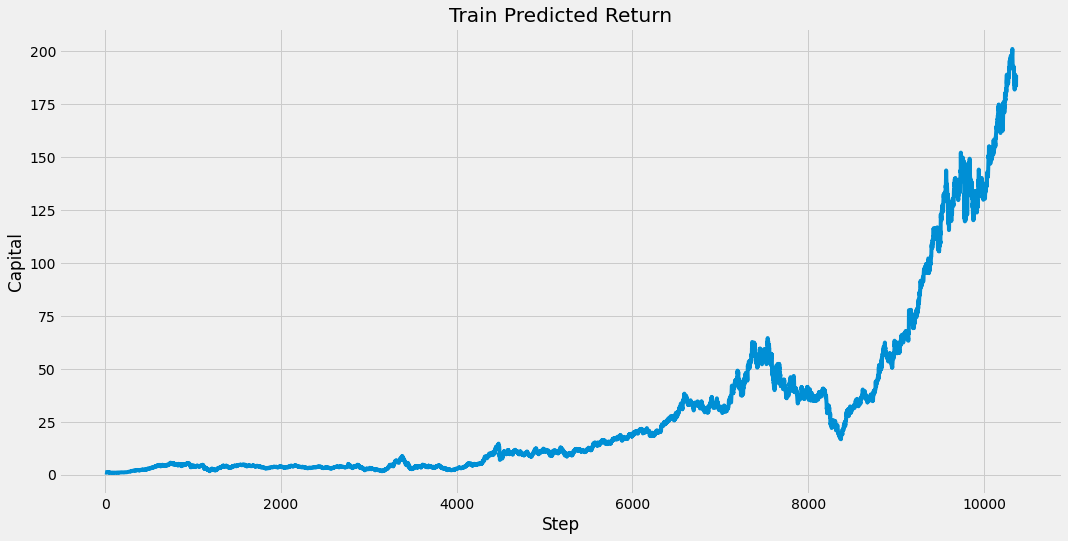

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Train Predicted Return')
plt.plot(result_sum_train_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

In [ ]:
count_max=0
count_plus=0
count_min=0
count_minus=0

result_sum_test=1.0
result_sum_test_array=[]
for i in range(len(y_test_np)):
    
    index=np.argmax(y_test_np[i])
    
    count_max+=1 if index==np.argmax(df[len(Y_train)+window+i:len(Y_train)+window+i+1].values/df[len(Y_train)+window+i-1:len(Y_train)+window+i].values) else 0
    count_plus+=1 if df[df.columns[index]][len(Y_train)+window+i]/df[df.columns[index]][len(Y_train)+window+i-1]>1 else 0
    count_min+=1 if np.argmin(y_test_np[i])==np.argmin(df[len(Y_train)+window+i:len(Y_train)+window+i+1].values/df[len(Y_train)+window+i-1:len(Y_train)+window+i].values) else 0
    count_minus+=1 if df[df.columns[np.argmin(y_test_np[i])]][len(Y_train)+window+i]/df[df.columns[np.argmin(y_test_np[i])]][len(Y_train)+window+i-1]<1 else 0

    result_sum_test*=df[df.columns[index]][len(Y_train)+window+i+1]/df[df.columns[index]][len(Y_train)+window+i]
    
    result_sum_test_array.append(result_sum_test)

In [ ]:
print("probability of guessing the highest growth: {0:.2%}".format(count_max/len(y_test_np)))
print("probability of guessing the growth up: {0:.2%}".format(count_plus/len(y_test_np)))
print("probability of guessing the lowest growth: {0:.2%}".format(count_min/len(y_test_np)))
print("probability of guessing the growth down: {0:.2%}".format(count_minus/len(y_test_np)))

probability of guessing the highest growth: 5.40%
probability of guessing the growth up: 53.32%
probability of guessing the lowest growth: 3.36%
probability of guessing the growth down: 47.65%


In [ ]:
print("deposit increase per day:{}%".format((result_sum_test**(1/len(y_test_np))-1)*100))

deposit increase per day:0.09313408102538112%


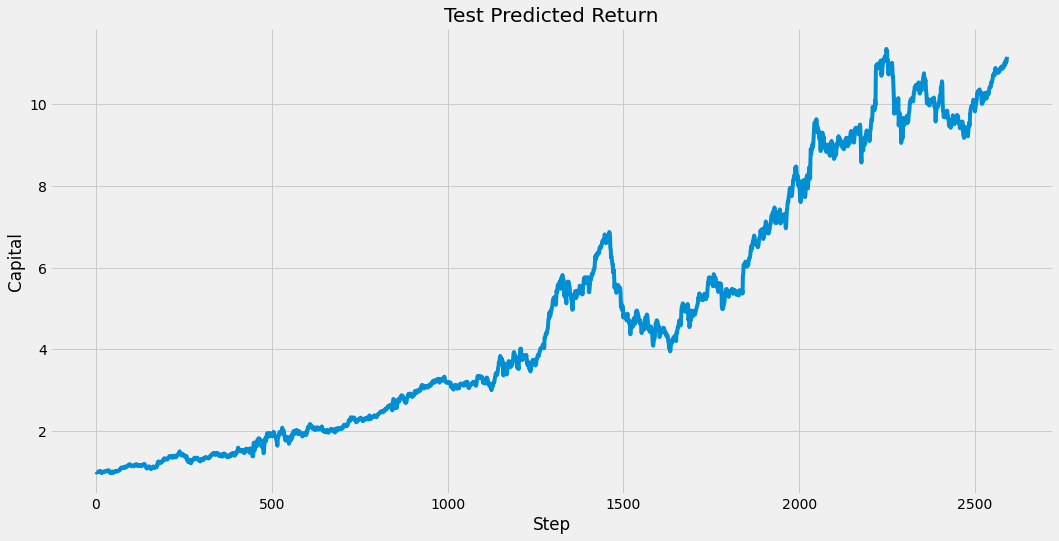

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Test Predicted Return')
plt.plot(result_sum_test_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

# SimpleRNN Network with for

In [ ]:
#Строим нейронку
model = Sequential()
model.add(SimpleRNN(50,return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))

for i in range(100):
    model.add(SimpleRNN(5,return_sequences = True))

model.add(SimpleRNN(50,return_sequences = False))
model.add(Dense(25))
model.add(Dense(Y_train.shape[1]))

In [ ]:
#Компилируем модель
model.compile(optimizer='adam',loss = 'mean_squared_error')

In [ ]:
#Тренируем модель
model.fit(X_train,Y_train,batch_size = 100, epochs = 28,validation_data=(X_valid,Y_valid))

Epoch 1/28
94/94 [==============================] - 153s 523ms/step - loss: 0.1761 - val_loss: 1.7797e-04
Epoch 2/28
94/94 [==============================] - 17s 178ms/step - loss: 3.2314e-04 - val_loss: 1.5386e-04
Epoch 3/28
94/94 [==============================] - 17s 178ms/step - loss: 3.1468e-04 - val_loss: 1.5186e-04
Epoch 4/28
94/94 [==============================] - 17s 178ms/step - loss: 3.2264e-04 - val_loss: 1.5318e-04
Epoch 5/28
94/94 [==============================] - 17s 178ms/step - loss: 3.0185e-04 - val_loss: 1.5684e-04
Epoch 6/28
94/94 [==============================] - 17s 178ms/step - loss: 3.2042e-04 - val_loss: 1.6080e-04
Epoch 7/28
94/94 [==============================] - 17s 179ms/step - loss: 3.1355e-04 - val_loss: 1.5497e-04
Epoch 8/28
94/94 [==============================] - 17s 178ms/step - loss: 3.2247e-04 - val_loss: 1.6141e-04
Epoch 9/28
94/94 [==============================] - 17s 176ms/step - loss: 3.1823e-04 - val_loss: 1.5647e-04
Epoch 10/28
94/94 [===

In [ ]:
y_train_pred=model.predict(X_train)
y_valid_pred=model.predict(X_valid)
y_test_pred=model.predict(X_test)

In [ ]:
y_train_np=np.vstack([y_train_pred,y_valid_pred])
y_test_np=y_test_pred

In [ ]:
count_max=0
count_plus=0
count_min=0
count_minus=0


result_sum_train=1.0
result_sum_train_array=[]
for i in range(len(y_train_np)):
    
    index=np.argmax(y_train_np[i])

    count_max+=1 if index==np.argmax(df[window+i:window+i+1].values/df[window+i-1:window+i].values) else 0
    count_plus+=1 if df[df.columns[index]][window+i]/df[df.columns[index]][window+i-1]>1 else 0
    count_min+=1 if np.argmin(y_train_np[i])==np.argmin(df[window+i:window+i+1].values/df[window+i-1:window+i].values) else 0
    count_minus+=1 if df[df.columns[np.argmin(y_train_np[i])]][window+i]/df[df.columns[np.argmin(y_train_np[i])]][window+i-1]<1 else 0

    result_sum_train*=df[df.columns[index]][window+i]/df[df.columns[index]][window+i-1]
    result_sum_train_array.append(result_sum_train)

In [ ]:
print("probability of guessing the highest growth: {0:.2%}".format(count_max/len(y_train_np)))
print("probability of guessing the growth up: {0:.2%}".format(count_plus/len(y_train_np)))
print("probability of guessing the lowest growth: {0:.2%}".format(count_min/len(y_train_np)))
print("probability of guessing the growth down: {0:.2%}".format(count_minus/len(y_train_np)))

probability of guessing the highest growth: 5.50%
probability of guessing the growth up: 43.73%
probability of guessing the lowest growth: 2.13%
probability of guessing the growth down: 45.03%


In [ ]:
print("deposit increase per day:{}%".format((result_sum_train**(1/len(y_train_np))-1)*100))

deposit increase per day:0.06839002286445073%


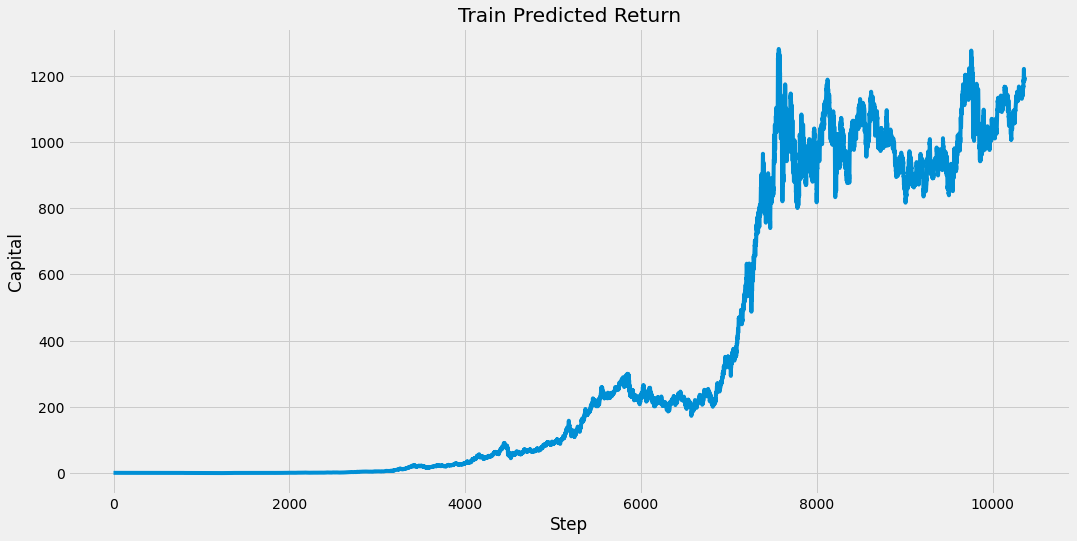

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Train Predicted Return')
plt.plot(result_sum_train_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

In [ ]:
count_max=0
count_plus=0
count_min=0
count_minus=0

result_sum_test=1.0
result_sum_test_array=[]
for i in range(len(y_test_np)):
    
    index=np.argmax(y_test_np[i])
    
    count_max+=1 if index==np.argmax(df[len(Y_train)+window+i:len(Y_train)+window+i+1].values/df[len(Y_train)+window+i-1:len(Y_train)+window+i].values) else 0
    count_plus+=1 if df[df.columns[index]][len(Y_train)+window+i]/df[df.columns[index]][len(Y_train)+window+i-1]>1 else 0
    count_min+=1 if np.argmin(y_test_np[i])==np.argmin(df[len(Y_train)+window+i:len(Y_train)+window+i+1].values/df[len(Y_train)+window+i-1:len(Y_train)+window+i].values) else 0
    count_minus+=1 if df[df.columns[np.argmin(y_test_np[i])]][len(Y_train)+window+i]/df[df.columns[np.argmin(y_test_np[i])]][len(Y_train)+window+i-1]<1 else 0

    result_sum_test*=df[df.columns[index]][len(Y_train)+window+i+1]/df[df.columns[index]][len(Y_train)+window+i]
    
    result_sum_test_array.append(result_sum_test)

In [ ]:
print("probability of guessing the highest growth: {0:.2%}".format(count_max/len(y_test_np)))
print("probability of guessing the growth up: {0:.2%}".format(count_plus/len(y_test_np)))
print("probability of guessing the lowest growth: {0:.2%}".format(count_min/len(y_test_np)))
print("probability of guessing the growth down: {0:.2%}".format(count_minus/len(y_test_np)))

probability of guessing the highest growth: 2.78%
probability of guessing the growth up: 51.74%
probability of guessing the lowest growth: 2.24%
probability of guessing the growth down: 49.31%


In [ ]:
print("deposit increase per day:{}%".format((result_sum_test**(1/len(y_test_np))-1)*100))

deposit increase per day:0.027703313914262395%


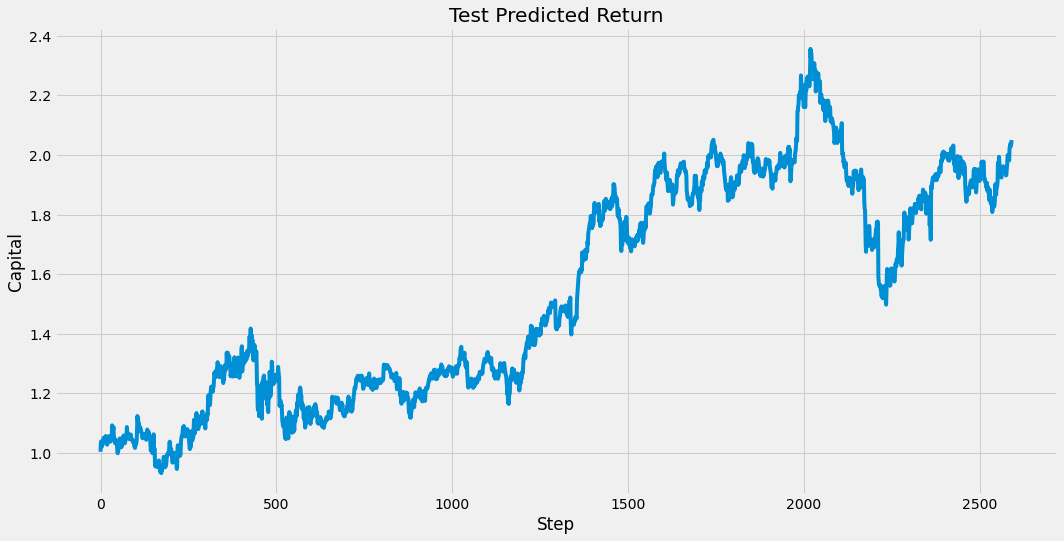

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Test Predicted Return')
plt.plot(result_sum_test_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

# SimpleRNN with activation

In [ ]:
#Строим нейронку
model = Sequential()
model.add(SimpleRNN(50,return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))

for i in range(100):
    model.add(SimpleRNN(5,return_sequences = True))
    model.add(layers.Activation(activations.tanh))

model.add(SimpleRNN(50,return_sequences = False))
model.add(Dense(25))
model.add(Dense(Y_train.shape[1]))

In [ ]:
#Компилируем модель
model.compile(optimizer='adam',loss = 'mean_squared_error')

In [ ]:
#Тренируем модель
model.fit(X_train,Y_train,batch_size = 100, epochs = 28,validation_data=(X_valid,Y_valid))

Epoch 1/28
94/94 [==============================] - 156s 531ms/step - loss: 0.2311 - val_loss: 1.9671e-04
Epoch 2/28
94/94 [==============================] - 17s 182ms/step - loss: 3.1565e-04 - val_loss: 1.5248e-04
Epoch 3/28
94/94 [==============================] - 17s 178ms/step - loss: 3.1131e-04 - val_loss: 1.5237e-04
Epoch 4/28
94/94 [==============================] - 17s 181ms/step - loss: 3.0188e-04 - val_loss: 1.5412e-04
Epoch 5/28
94/94 [==============================] - 17s 180ms/step - loss: 3.0504e-04 - val_loss: 1.5858e-04
Epoch 6/28
94/94 [==============================] - 17s 178ms/step - loss: 3.0595e-04 - val_loss: 1.5455e-04
Epoch 7/28
94/94 [==============================] - 17s 180ms/step - loss: 3.1157e-04 - val_loss: 1.5594e-04
Epoch 8/28
94/94 [==============================] - 17s 180ms/step - loss: 3.1410e-04 - val_loss: 1.6625e-04
Epoch 9/28
94/94 [==============================] - 17s 178ms/step - loss: 3.1474e-04 - val_loss: 1.5312e-04
Epoch 10/28
94/94 [===

In [ ]:
y_train_pred=model.predict(X_train)
y_valid_pred=model.predict(X_valid)
y_test_pred=model.predict(X_test)

In [ ]:
y_train_np=np.vstack([y_train_pred,y_valid_pred])
y_test_np=y_test_pred

In [ ]:
count_max=0
count_plus=0
count_min=0
count_minus=0


result_sum_train=1.0
result_sum_train_array=[]
for i in range(len(y_train_np)):
    
    index=np.argmax(y_train_np[i])

    count_max+=1 if index==np.argmax(df[window+i:window+i+1].values/df[window+i-1:window+i].values) else 0
    count_plus+=1 if df[df.columns[index]][window+i]/df[df.columns[index]][window+i-1]>1 else 0
    count_min+=1 if np.argmin(y_train_np[i])==np.argmin(df[window+i:window+i+1].values/df[window+i-1:window+i].values) else 0
    count_minus+=1 if df[df.columns[np.argmin(y_train_np[i])]][window+i]/df[df.columns[np.argmin(y_train_np[i])]][window+i-1]<1 else 0

    result_sum_train*=df[df.columns[index]][window+i]/df[df.columns[index]][window+i-1]
    result_sum_train_array.append(result_sum_train)

In [ ]:
print("probability of guessing the highest growth: {0:.2%}".format(count_max/len(y_train_np)))
print("probability of guessing the growth up: {0:.2%}".format(count_plus/len(y_train_np)))
print("probability of guessing the lowest growth: {0:.2%}".format(count_min/len(y_train_np)))
print("probability of guessing the growth down: {0:.2%}".format(count_minus/len(y_train_np)))

probability of guessing the highest growth: 4.42%
probability of guessing the growth up: 34.44%
probability of guessing the lowest growth: 3.04%
probability of guessing the growth down: 38.21%


In [ ]:
print("deposit increase per day:{}%".format((result_sum_train**(1/len(y_train_np))-1)*100))

deposit increase per day:0.04799969835369566%


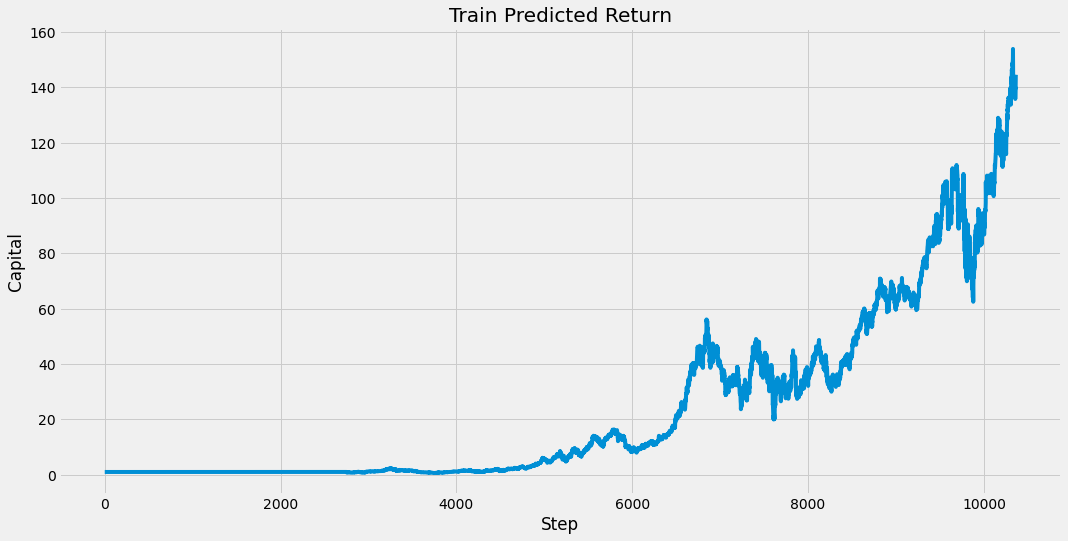

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Train Predicted Return')
plt.plot(result_sum_train_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

In [ ]:
count_max=0
count_plus=0
count_min=0
count_minus=0

result_sum_test=1.0
result_sum_test_array=[]
for i in range(len(y_test_np)):
    
    index=np.argmax(y_test_np[i])
    
    count_max+=1 if index==np.argmax(df[len(Y_train)+window+i:len(Y_train)+window+i+1].values/df[len(Y_train)+window+i-1:len(Y_train)+window+i].values) else 0
    count_plus+=1 if df[df.columns[index]][len(Y_train)+window+i]/df[df.columns[index]][len(Y_train)+window+i-1]>1 else 0
    count_min+=1 if np.argmin(y_test_np[i])==np.argmin(df[len(Y_train)+window+i:len(Y_train)+window+i+1].values/df[len(Y_train)+window+i-1:len(Y_train)+window+i].values) else 0
    count_minus+=1 if df[df.columns[np.argmin(y_test_np[i])]][len(Y_train)+window+i]/df[df.columns[np.argmin(y_test_np[i])]][len(Y_train)+window+i-1]<1 else 0

    result_sum_test*=df[df.columns[index]][len(Y_train)+window+i+1]/df[df.columns[index]][len(Y_train)+window+i]
    
    result_sum_test_array.append(result_sum_test)

In [ ]:
print("probability of guessing the highest growth: {0:.2%}".format(count_max/len(y_test_np)))
print("probability of guessing the growth up: {0:.2%}".format(count_plus/len(y_test_np)))
print("probability of guessing the lowest growth: {0:.2%}".format(count_min/len(y_test_np)))
print("probability of guessing the growth down: {0:.2%}".format(count_minus/len(y_test_np)))

probability of guessing the highest growth: 4.40%
probability of guessing the growth up: 51.81%
probability of guessing the lowest growth: 2.55%
probability of guessing the growth down: 46.53%


In [ ]:
print("deposit increase per day:{}%".format((result_sum_test**(1/len(y_test_np))-1)*100))

deposit increase per day:0.06375065149542003%


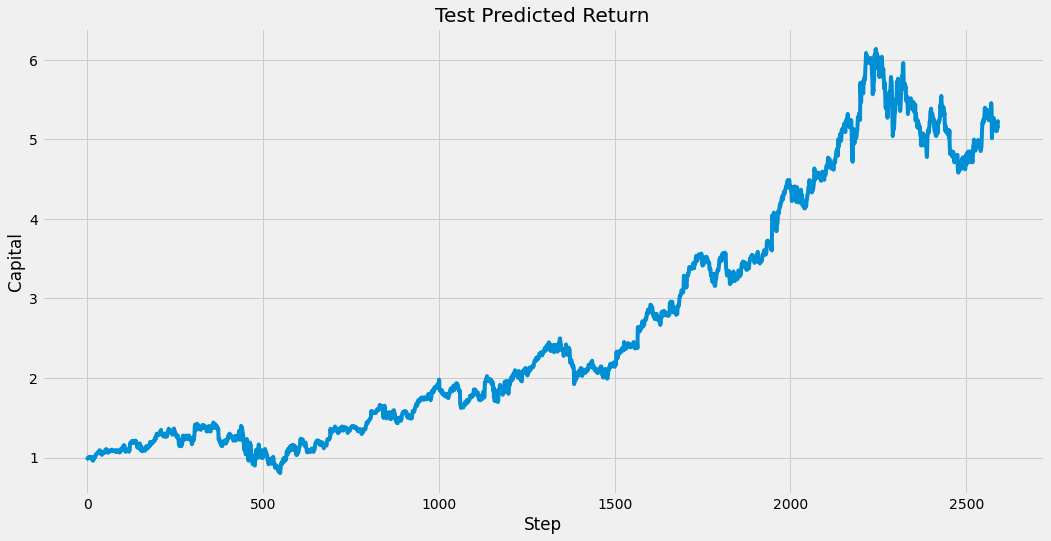

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Test Predicted Return')
plt.plot(result_sum_test_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

# SimpleRNN with RELU activation

In [ ]:
print((X_train.shape[1],X_train.shape[2]))

(10, 27)


In [ ]:
#Строим нейронку
model = Sequential()
model.add(SimpleRNN(50,return_sequences = True, input_shape = (X_train.shape[1],X_train.shape[2])))

for i in range(100):
    model.add(SimpleRNN(5,return_sequences = True))
    model.add(layers.Activation(activations.relu))

model.add(SimpleRNN(50,return_sequences = False))
model.add(Dense(25))
model.add(Dense(Y_train.shape[1]))

In [ ]:
#Компилируем модель
model.compile(optimizer='adam',loss = 'mean_squared_error')

In [ ]:
#Тренируем модель
model.fit(X_train,Y_train,batch_size = 100, epochs = 28,validation_data=(X_valid,Y_valid))

Epoch 1/28
94/94 [==============================] - 160s 542ms/step - loss: 0.1456 - val_loss: 1.6438e-04
Epoch 2/28
94/94 [==============================] - 17s 182ms/step - loss: 3.2084e-04 - val_loss: 1.5120e-04
Epoch 3/28
94/94 [==============================] - 17s 182ms/step - loss: 3.0920e-04 - val_loss: 1.5183e-04
Epoch 4/28
94/94 [==============================] - 17s 181ms/step - loss: 3.0669e-04 - val_loss: 1.5873e-04
Epoch 5/28
94/94 [==============================] - 17s 185ms/step - loss: 3.0661e-04 - val_loss: 1.5973e-04
Epoch 6/28
94/94 [==============================] - 17s 182ms/step - loss: 3.2722e-04 - val_loss: 1.5476e-04
Epoch 7/28
94/94 [==============================] - 17s 182ms/step - loss: 3.1562e-04 - val_loss: 1.5267e-04
Epoch 8/28
94/94 [==============================] - 17s 183ms/step - loss: 3.1997e-04 - val_loss: 1.5285e-04
Epoch 9/28
94/94 [==============================] - 17s 181ms/step - loss: 3.2291e-04 - val_loss: 1.5377e-04
Epoch 10/28
94/94 [===

In [ ]:
y_train_pred=model.predict(X_train)
y_valid_pred=model.predict(X_valid)
y_test_pred=model.predict(X_test)

In [ ]:
print(X_test.shape)

(2592, 10, 27)


In [ ]:
y_train_np=np.vstack([y_train_pred,y_valid_pred])
y_test_np=y_test_pred

In [ ]:
count_max=0
count_plus=0
count_min=0
count_minus=0


result_sum_train=1.0
result_sum_train_array=[]
for i in range(len(y_train_np)):
    
    index=np.argmax(y_train_np[i])

    count_max+=1 if index==np.argmax(df[window+i:window+i+1].values/df[window+i-1:window+i].values) else 0
    count_plus+=1 if df[df.columns[index]][window+i]/df[df.columns[index]][window+i-1]>1 else 0
    count_min+=1 if np.argmin(y_train_np[i])==np.argmin(df[window+i:window+i+1].values/df[window+i-1:window+i].values) else 0
    count_minus+=1 if df[df.columns[np.argmin(y_train_np[i])]][window+i]/df[df.columns[np.argmin(y_train_np[i])]][window+i-1]<1 else 0

    result_sum_train*=df[df.columns[index]][window+i]/df[df.columns[index]][window+i-1]
    result_sum_train_array.append(result_sum_train)

In [ ]:
print("probability of guessing the highest growth: {0:.2%}".format(count_max/len(y_train_np)))
print("probability of guessing the growth up: {0:.2%}".format(count_plus/len(y_train_np)))
print("probability of guessing the lowest growth: {0:.2%}".format(count_min/len(y_train_np)))
print("probability of guessing the growth down: {0:.2%}".format(count_minus/len(y_train_np)))

probability of guessing the highest growth: 8.81%
probability of guessing the growth up: 35.66%
probability of guessing the lowest growth: 4.11%
probability of guessing the growth down: 45.28%


In [ ]:
print("deposit increase per day:{}%".format((result_sum_train**(1/len(y_train_np))-1)*100))

deposit increase per day:0.045206995974034214%


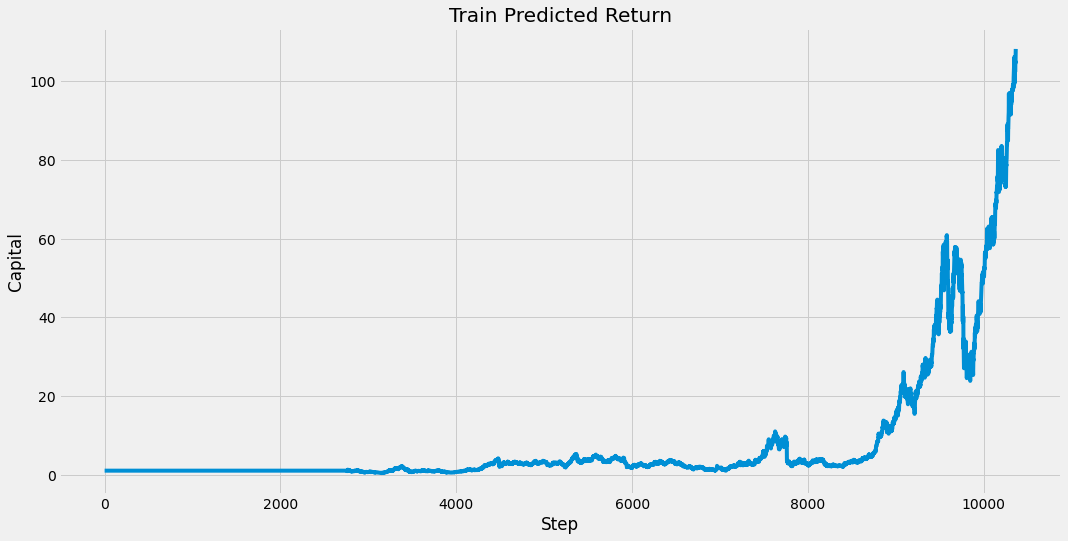

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Train Predicted Return')
plt.plot(result_sum_train_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

In [ ]:
count_max=0
count_plus=0
count_min=0
count_minus=0

result_sum_test=1.0
result_sum_test_array=[]
for i in range(len(y_test_np)):
    
    index=np.argmax(y_test_np[i])
    
    count_max+=1 if index==np.argmax(df[len(Y_train)+window+i:len(Y_train)+window+i+1].values/df[len(Y_train)+window+i-1:len(Y_train)+window+i].values) else 0
    count_plus+=1 if df[df.columns[index]][len(Y_train)+window+i]/df[df.columns[index]][len(Y_train)+window+i-1]>1 else 0
    count_min+=1 if np.argmin(y_test_np[i])==np.argmin(df[len(Y_train)+window+i:len(Y_train)+window+i+1].values/df[len(Y_train)+window+i-1:len(Y_train)+window+i].values) else 0
    count_minus+=1 if df[df.columns[np.argmin(y_test_np[i])]][len(Y_train)+window+i]/df[df.columns[np.argmin(y_test_np[i])]][len(Y_train)+window+i-1]<1 else 0

    result_sum_test*=df[df.columns[index]][len(Y_train)+window+i+1]/df[df.columns[index]][len(Y_train)+window+i]
    
    result_sum_test_array.append(result_sum_test)

In [ ]:
print("probability of guessing the highest growth: {0:.2%}".format(count_max/len(y_test_np)))
print("probability of guessing the growth up: {0:.2%}".format(count_plus/len(y_test_np)))
print("probability of guessing the lowest growth: {0:.2%}".format(count_min/len(y_test_np)))
print("probability of guessing the growth down: {0:.2%}".format(count_minus/len(y_test_np)))

probability of guessing the highest growth: 9.07%
probability of guessing the growth up: 52.82%
probability of guessing the lowest growth: 3.70%
probability of guessing the growth down: 47.49%


In [ ]:
print("deposit increase per day:{}%".format((result_sum_test**(1/len(y_test_np))-1)*100))

deposit increase per day:0.10039562876495989%


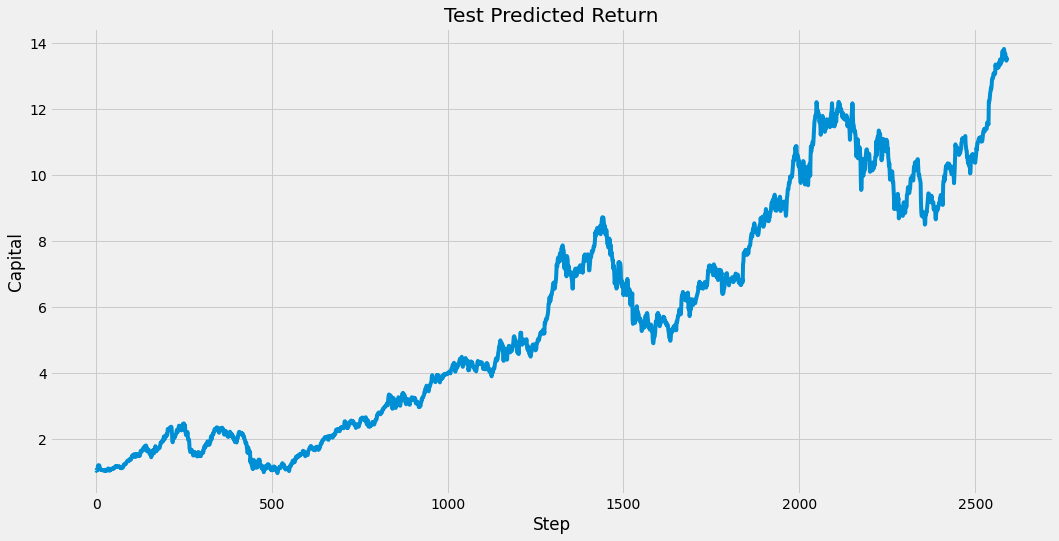

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Test Predicted Return')
plt.plot(result_sum_test_array)
plt.xlabel('Step')
plt.ylabel('Capital')
plt.show()

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_238 (SimpleRNN)   (None, 10, 50)            3900      
_________________________________________________________________
simple_rnn_239 (SimpleRNN)   (None, 10, 5)             280       
_________________________________________________________________
module_wrapper_100 (ModuleWr (None, 10, 5)             0         
_________________________________________________________________
simple_rnn_240 (SimpleRNN)   (None, 10, 5)             55        
_________________________________________________________________
module_wrapper_101 (ModuleWr (None, 10, 5)             0         
_________________________________________________________________
simple_rnn_241 (SimpleRNN)   (None, 10, 5)             55        
_________________________________________________________________
module_wrapper_102 (ModuleWr (None, 10, 5)            

In [ ]:
model.save_weights("/content/weights_deep_model_sru_relu_dema.h5")